# **Project 2 - Embedding and Recurrent Neural Networks: Group 4**

**CPSC 585-02**: Artificial Neural Networks

**Due Date**: April 29, 2023

**Team Members:**

*   Kishore Shankar Abimanyu

*   Angelica Cabato

*   Nicholas Fonseca

*   Sasha Ramnath Rahane

*   Renu Sushant Velhal

*   Aniket Wattamwar


The goal of this project is to use the text in a RateMyProfessor.com review to predict the difficulty and quality score the reviewer assigned to the professor. To do this, we used the datasets provided by Dr. Hibo Je's - specifically the sample data - and dataset provided on Kaggle. We used NLTK to preprocess the dataset, and then used GLoVe's pre-trained word embedding.

Further down in this notebook are the various models we built for this project: LSTM, GRU, and Text Classification. We trained a LSTM and a GRU model, finding that the GRU model outperformed the LSTM. Finally, we trained a model utilizing text classification and found that our training MSE was .670. Although the models performed similarly, the Text Classification model ultimately had better performance in terms of loss and metric scores.

# Loading Dataset

First, we will load the two example datasets provided in the project description. The two datasets are Dr. Je's sample data, and the Kaggle data.


First, we mount drive into colab.

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')


Mounted at /content/drive


Then, Dr. Je's sample dataset is loaded.



In [ ]:
csvFile = '/content/drive/MyDrive/RateMyProfessor_Sample data.csv'

Quality, difficulty, and comments sections are read and stored into a pandas dataframe.

In [ ]:
import pandas as pd
csvdf = pd.read_csv(csvFile, usecols=['student_star', 'student_difficult', 'comments'])

Display the dataframe

In [ ]:
print(csvdf)

       student_star  student_difficult  \
0               5.0                3.0   
1               5.0                2.0   
2               4.0                3.0   
3               5.0                3.0   
4               5.0                1.0   
...             ...                ...   
19995           1.5                5.0   
19996           2.5                4.0   
19997           5.0                3.0   
19998           4.0                5.0   
19999           5.0                2.0   

                                                comments  
0      This class is hard, but its a two-in-one gen-e...  
1      Definitely going to choose Prof. Looney\'s cla...  
2      I overall enjoyed this class because the assig...  
3      Yes, it\'s possible to get an A but you\'ll de...  
4      Professor Looney has great knowledge in Astron...  
...                                                  ...  
19995   Great sense of humor!!!! Love parasites now!!!!!  
19996  he is a really n

Appears to be correct. This provides us with 20000 samples.

Next we use glom to read in the JSON data

In [ ]:
!pip install glom
from glom import glom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.2 MB/s eta 0:00:00


Now, we read Kaggle's JSON file in, also pulling out the comments, quality, and difficulty.

In [ ]:
import json
# Open the file for reading

jsonFile = '/content/drive/MyDrive/all_reviews.json'

#read csv file into

jsondf = pd.read_json(jsonFile)

comments=jsondf[0].apply(lambda row: glom(row, 'Comment'))
quality=jsondf[0].apply(lambda row: glom(row, 'Quality'))
difficulty=jsondf[0].apply(lambda row: glom(row, 'Difficulty'))

print(comments)
print(quality)
print(difficulty)



0      Professor Nichols is super nice and very whole...
1      Prof Humes is really knowledgeable, but her le...
2      If you fall behind it's almost impossible to c...
3      Prof. Meyer is intensely brilliant and provoke...
4      Would not recommend taking him for fhs or even...
                             ...                        
283       He's super brilliant, passionate, and helpful.
284    Took IBC with Sanii and really enjoyed him. I ...
285    This was my first college bio class and it was...
286    Henri Cole is not only an amazing poet, but al...
287    As my first econ class, I got exactly what I e...
Name: 0, Length: 288, dtype: object
0      5.0
1      4.0
2      3.0
3      4.5
4      1.0
      ... 
283    5.0
284    5.0
285    3.5
286    5.0
287    4.0
Name: 0, Length: 288, dtype: object
0      2.0
1      4.0
2      4.0
3      4.0
4      4.0
      ... 
283    3.0
284    5.0
285    3.0
286    2.0
287    3.0
Name: 0, Length: 288, dtype: object


## **Cleaning and Combining Datasets**

We then combine the two datasets, and clear out any garbage data.

**Pre-processing Larger Dataset from Dr. Hibo Je at Tsinghua University**

In [ ]:
# Looking at the csvdf data format
csvdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_star       19995 non-null  float64
 1   student_difficult  19995 non-null  float64
 2   comments           19993 non-null  object 
dtypes: float64(2), object(1)
memory usage: 468.9+ KB


In [ ]:
# Dropping rows with missing values
csvdf = csvdf.dropna()

In [ ]:
# Checking how many rows were dropped - only dropped 2 rows.
csvdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19993 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_star       19993 non-null  float64
 1   student_difficult  19993 non-null  float64
 2   comments           19993 non-null  object 
dtypes: float64(2), object(1)
memory usage: 624.8+ KB


**Pre-processing Smaller Dataset from Kaggle**

In [ ]:
# Checking if comments, quality, or difficult have any Na's
print(comments.hasnans)
print(quality.hasnans)
print(difficulty.hasnans)

False
False
False


**Combining datasets into one DataFrame for ease of training and testing**

In [ ]:
# Create new dataframe to combine "comments" from both datasets
sample_comments = pd.Series(dtype='string', name='comments')

sample_comments = pd.concat([csvdf.comments, comments], ignore_index=True, axis=0)

# Verify that datasets were combined correctly
print("csvdf: ", csvdf.comments[0])
print("jsondf: ", comments[0])

i = 0

print("sample_comments (csvdf): ", sample_comments[i])
print("sample_comments (jsondf): ", sample_comments[i+csvdf.comments.shape[0]])

csvdf:  This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra credit every week. Very funny dude. Not much more I can say.
jsondf:  Professor Nichols is super nice and very wholesome! There is a lot of reading, but you can get by without doing very much of it. He does talk a LOT and doesn't foster as much discussion, but I think the latter might also be because people stop doing the readings a few weeks in. He does appreciate participation and gives great essay feedback!
sample_comments (csvdf):  This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra credit every week. Very funny dude. Not much more I can say.
sample_comments (jsondf):  Professor Nichols is super nice and very wholesome! There is a lot of reading, b

In [ ]:
# Create new dataframe to combine "quality" from both datasets
sample_quality = pd.Series(dtype='float64', name='quality')

sample_quality = pd.concat([csvdf.student_star,quality], ignore_index=True, axis=0)
sample_quality = sample_quality.astype('float64')

# Verify that datasets were combined correctly
print("csvdf: ", csvdf.student_star[0])
print("jsondf: ", quality[0])

i = 0

print("sample_quality (csvdf): ", sample_quality[i])
print("sample_quality  (jsondf): ", sample_quality[i+csvdf.student_star.shape[0]])

csvdf:  5.0
jsondf:  5.0
sample_quality (csvdf):  5.0
sample_quality  (jsondf):  5.0


In [ ]:
# Create new dataframe to combine "difficulty" from both datasets
sample_difficulty = pd.Series(dtype='float64',name='difficulty')

sample_difficulty = pd.concat([csvdf.student_difficult, difficulty], ignore_index=True, axis=0)
sample_difficulty = sample_difficulty.astype('float64')

# Verify that datasets were combined correctly
print("csvdf: ", csvdf.student_difficult[0])
print("jsondf: ", difficulty[0])

i = 0

print("sample_difficulty (csvdf): ", sample_difficulty[i])
print("sample_difficulty (jsondf): ", sample_difficulty[i+csvdf.student_difficult.shape[0]])

csvdf:  3.0
jsondf:  2.0
sample_difficulty (csvdf):  3.0
sample_difficulty (jsondf):  2.0


# Data Analysis

In Project 1 and the introductory project, we were able to gain insight into what was occurring in our dataset by displaying the images in the dataset. For textual data, we have a more difficult time understanding our dataset and therefore must make a larger effort to do so. This effort is documented in this section.

We will analyze the review text for following: word/character count. A previous version of this section included some analysis, including grammar and spelling, positive and negative words, racial bias, and gender bias. This was lost due to a technical error.

First, we will analyze the word and character counts of the review text for professors. On first glance, these can vary greatly. Consider these two reviews that gave the professor a 5 in quality and a 3 in difficulty:

```Great professor,```

and

```Professor Knox is Ideal. He seamlessly engages students of all intellects with the proper amount of abstraction for efficient growth and immersion in the subject matter. He knows how to explain complex concepts in a thorough yet pragmatic way. A true gem.```

Despite giving the same score, the counts vary wildly. It is worth looking into whether these counts relate to the scores in any way

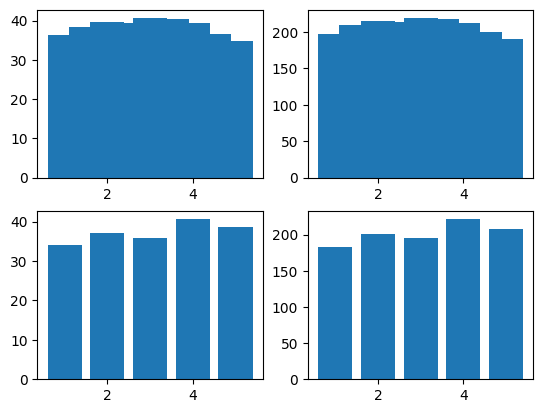

In [ ]:
import matplotlib.pyplot as plt


sample_word_counts = [len(comments.split()) for comments in sample_comments]
sample_character_counts = [len(comments) for comments in sample_comments]

quality_wc = {1.0:[], 1.5:[], 2.0:[], 2.5:[], 3.0:[], 3.5:[], 4.0:[], 4.5:[], 5.0:[]}
quality_cc = {1.0:[], 1.5:[], 2.0:[], 2.5:[], 3.0:[], 3.5:[], 4.0:[], 4.5:[], 5.0:[]}

diff_wc = {1.0:[], 2.0:[], 3.0:[], 4.0:[], 5.0:[]}
diff_cc = {1.0:[], 2.0:[], 3.0:[], 4.0:[], 5.0:[]}

for rating_idx in range(len(sample_quality)):
  quality_wc[sample_quality[rating_idx]].append(sample_word_counts[rating_idx])
  quality_cc[sample_quality[rating_idx]].append(sample_character_counts[rating_idx])
  diff_wc[sample_difficulty[rating_idx]].append(sample_word_counts[rating_idx])
  diff_cc[sample_difficulty[rating_idx]].append(sample_character_counts[rating_idx])


plt.subplot(2,2,1)
plt.bar(list(quality_wc.keys()), [sum(i) / len(i) for i in quality_wc.values()])
plt.subplot(2,2,2)
plt.bar(list(quality_cc.keys()), [sum(i) / len(i) for i in quality_cc.values()])

plt.subplot(2,2,3)
plt.bar(list(diff_wc.keys()), [sum(i) / len(i) for i in diff_wc.values()])
plt.subplot(2,2,4)
plt.bar(list(diff_cc.keys()), [sum(i) / len(i) for i in diff_cc.values()])
plt.show()

We can see that the longest reviews are actually those that have a more middling rating. 5 star reviews actually tend to be the shortest, which isn't too surprising. More surprising is the length of 1 star reviews, we expected these to be the longest as they likely include a good amount of long rants.

Difficulty shows a different story - longer reviews tend to be for more difficult classes.

We should also analyze what ratings our reviews hold.

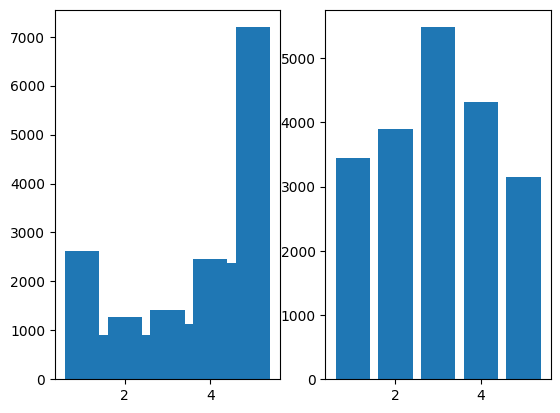

In [ ]:
plt.subplot(1,2,1)
plt.bar(list(quality_wc.keys()), [len(i) for i in quality_wc.values()])
plt.subplot(1,2,2)
plt.bar(list(diff_wc.keys()), [len(i) for i in diff_wc.values()])
plt.show()

There are far more 5 star reviews than any other reviews in our dataset, with 1 star coming in next at less than half the reviews. This is fine, as we should need to favor 5 star reviews if they are more common.

Difficulty is closer, with most professors rated being at the midpoint in difficulty.

While work was lost in other categories and time does not permit the work to be repeated, here is a small example of the work that was done. Let's use age bias as an example: an easy way to find bias is to search through the reviews for words that could imply age bias, such as "old". Our neural network should end up finding features like this, but we can also do it by hand to see the effects this language has on reviews. See below:

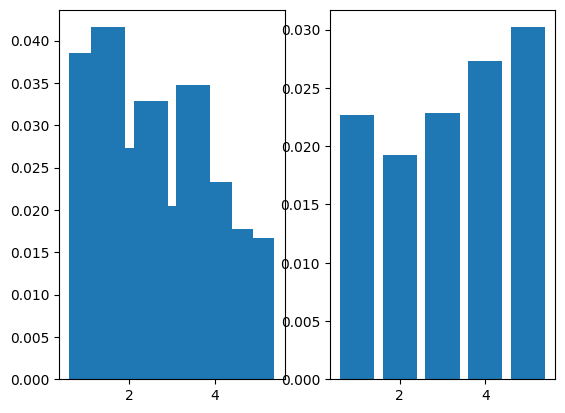

In [ ]:
rbias_qual = {1.0:0, 1.5:0, 2.0:0, 2.5:0, 3.0:0, 3.5:0, 4.0:0, 4.5:0, 5.0:0}

rbias_diff = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0}
for rating_idx in range(len(sample_quality)):
  if "old" in sample_comments[rating_idx]:
    rbias_qual[sample_quality[rating_idx]] += 1
    rbias_diff[sample_difficulty[rating_idx]] += 1

for i in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
  rbias_qual[i] = rbias_qual[i] / len(quality_wc[i])
  try:
    rbias_diff[i] = rbias_diff[i] / len(diff_wc[i])
  except KeyError:
    pass

plt.subplot(1,2,1)
plt.bar(list(rbias_qual.keys()), rbias_qual.values())
plt.subplot(1,2,2)
plt.bar(list(rbias_diff.keys()), rbias_diff.values())
plt.show()

Professors that students perceive as old (or at least are willing to call old while reviewing) receive more bad and difficult reviews than other professors. 4% of all 1  and 1.5 star reviews call their professor old at some point.

Another simple example we can do is gender bias - we can simply see which pronouns are used in the review. This unfortunately leaves out non-binary professors (we cannot check for "they", as it could be used in other contexts) and assumes the students are not misgendering their professors, but it is the easiest way to compare if gender affects scores

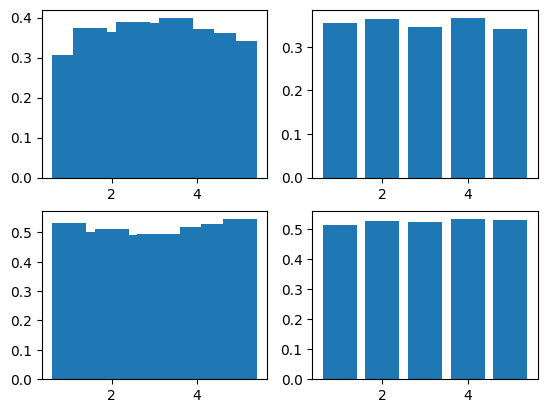

In [ ]:
mbias_qual = {1.0:0, 1.5:0, 2.0:0, 2.5:0, 3.0:0, 3.5:0, 4.0:0, 4.5:0, 5.0:0}
mbias_diff = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0}
wbias_qual = {1.0:0, 1.5:0, 2.0:0, 2.5:0, 3.0:0, 3.5:0, 4.0:0, 4.5:0, 5.0:0}
wbias_diff = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0}
for rating_idx in range(len(sample_quality)):
  if "she" in sample_comments[rating_idx].lower() or "her" in sample_comments[rating_idx].lower():
    wbias_qual[sample_quality[rating_idx]] += 1
    wbias_diff[sample_difficulty[rating_idx]] += 1
  elif "he" in sample_comments[rating_idx].lower() or "his" in sample_comments[rating_idx].lower():
    mbias_qual[sample_quality[rating_idx]] += 1
    mbias_diff[sample_difficulty[rating_idx]] += 1

for i in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
  mbias_qual[i] = mbias_qual[i] / len(quality_wc[i])
  wbias_qual[i] = wbias_qual[i] / len(quality_wc[i])
  try:
    mbias_diff[i] = mbias_diff[i] / len(diff_wc[i])
    wbias_diff[i] = wbias_diff[i] / len(diff_wc[i])
  except KeyError:
    pass

plt.subplot(2,2,1)
plt.bar(list(mbias_qual.keys()), mbias_qual.values())
plt.subplot(2,2,2)
plt.bar(list(mbias_diff.keys()), mbias_diff.values())
plt.subplot(2,2,3)
plt.bar(list(wbias_qual.keys()), wbias_qual.values())
plt.subplot(2,2,4)
plt.bar(list(wbias_diff.keys()), wbias_diff.values())
plt.show()

From this, we can observe that students are more likely to give women more extreme reviews and more likely to give men more middling reviews.

Past work included more terms, categories, examples, and encodings that would allow a classical model to be trained on the data. This model would have allowed for comparison between naive analysis and the RNN.

# **NLTK Pre-Processing**

Next, we prepare the Natural Language Toolkit and use it to perform lemmatization. From there we split the data into training and test splits.

In [ ]:
# import the Natural Language Toolkit and download relevent data/packages
import nltk
nltk.download('all')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
# Pre-processing comments using NLTK

import string
stop_words = stopwords.words('english')

def nlp_preprocessing(comment):

  # Remove punctuation
  new_comment = comment.translate(str.maketrans('', '', string.punctuation))

  # Convert to lowercase and tokenize the comment
  tokens = word_tokenize(new_comment.lower())

  # Remove stop words from the comment
  cleaned_tokens = [token for token in tokens if token not in stop_words]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in cleaned_tokens]

  # Join the lemmatized_tokens back into a string and return new comment
  processed_comment = ' '.join(lemmatized_tokens)

  return processed_comment

In [ ]:
# apply nlp_preprocessing function to entire comment series
sample_comments = sample_comments.apply(nlp_preprocessing)

In [ ]:
# verifying nlp_preprocessing with a few examples
print(sample_comments[0])
print(sample_comments[csvdf.comments.shape[0]])
print(sample_comments[sample_comments.shape[0]-1])

class hard twoinone gened knockout content stimulating unlike class actually participate pas section easy offer extra credit every week funny dude much say
professor nichols super nice wholesome lot reading get without much talk lot doesnt foster much discussion think latter might also people stop reading week appreciate participation give great essay feedback
first econ class got exactly expected lecture heavy intro course solid lecture crack class super easy fall behind miss class two textbook followed extent lecture note super helpful flexible due datesgives extension


In [ ]:
import numpy as np

print(type(sample_comments))
print(type(sample_quality))
print(type(sample_difficulty))

sample_comments = np.asarray(sample_comments)
sample_quality = np.asarray(sample_quality)
sample_difficulty = np.asarray(sample_difficulty)

print(type(sample_comments))
print(type(sample_quality))
print(type(sample_difficulty))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**Divide Training and Testing batches**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(sample_comments, sample_quality, sample_difficulty, test_size=0.2)

In [ ]:
# Verifying training sets against original data - csvdf
print("Comment: ", X_train[0])
print("Quality: ", y1_train[0])
print("Difficulty: ", y2_train[0])

Comment:  pro1knowledgeable aspect u history 2makes lecture interesting 3usually friendly con1clearly liberali cant even tell separating fact opinion2tough classhigh dependency note 3lots reading 4having background history nearly necessary 5disorganized manner thought speech writing
Quality:  3.0
Difficulty:  4.0


In [ ]:
# Original dataset for comparison - csvdf
print(csvdf.loc[0])

student_star                                                       5.0
student_difficult                                                  3.0
comments             This class is hard, but its a two-in-one gen-e...
Name: 0, dtype: object


In [ ]:
print(type(X_train))
print(type(y1_train))
print(type(y2_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **Word Embedding**




In this section, we load the pre-trained GLoVe word embeddings and apply then to the dataset.

Import dependencies

In [ ]:
 import os
 import urllib.request

 Directly access the files from the URL

In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7fc527e42d40>)

Unzipping the file

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


More dependencies

In [ ]:
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np

Loading Word Embeddings from a GloVe File

In [ ]:
# Initialize an empty dictionary to hold the embeddings

emmbedding_dict = {}
# Open the file containing the word embeddings

with open('/content/glove.6B.200d.txt','r') as f:

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')

#Add the word and its corresponding vector to the dictionary
    emmbedding_dict[word]=vector

 Accessing the embedding vector for the word 'good'


In [ ]:
emmbedding_dict['good']

array([ 5.1507e-01,  3.5596e-01,  1.5710e-01, -7.4075e-02, -2.5446e-01,
       -1.1357e-01, -4.9943e-01, -1.2626e-01,  3.8851e-01,  5.4204e-01,
        1.0479e-01,  4.4099e-01, -6.5490e-02,  5.8463e-02,  4.1150e-01,
        5.6709e-01, -1.1869e-01,  2.5107e-01,  2.5640e-01, -2.1615e-01,
        6.4170e-01,  2.7875e+00,  1.2036e-01,  4.9481e-02,  2.4843e-01,
       -6.7390e-01,  1.1957e-03,  3.5802e-01, -1.7588e-01, -3.9135e-01,
       -1.4093e-02,  2.3610e-01, -4.3184e-01, -2.7045e-02,  2.2829e-02,
       -2.8283e-01, -5.0008e-01, -1.1275e-01, -4.5002e-01,  3.3634e-01,
       -5.7722e-03,  3.3005e-01, -2.4671e-01,  1.7358e-01, -3.5508e-01,
       -3.9378e-02,  4.8834e-01,  1.4180e-01, -1.7579e-01,  3.1760e-01,
       -1.5194e-01, -1.1244e-01, -7.0078e-02,  7.4877e-01, -6.2074e-02,
       -1.7296e-01,  1.5001e-01, -5.8035e-02,  1.9471e-01, -2.9521e-01,
        5.0281e-01, -3.3074e-01, -5.4041e-01,  6.4659e-02,  4.1465e-02,
        4.9930e-01,  8.0902e-02,  4.7806e-01,  5.8307e-01,  4.08

Checking data tpye of sample comments

In [ ]:
print(sample_comments.dtype)

object


Find the maximum number of words

In [ ]:
# split each sentence in the 'my_column' column into a list of words and find the maximum length
df1=pd.DataFrame(sample_comments, columns=['Comments'])
max_words = df1['Comments'].str.split().apply(len).max()

# print the maximum number of words
print('Maximum number of words:', max_words)

Maximum number of words: 65


In [ ]:
print(sample_comments)

['class hard twoinone gened knockout content stimulating unlike class actually participate pas section easy offer extra credit every week funny dude much say'
 'definitely going choose prof looney class interesting class easy bring note exam dont need remember lot lot bonus point available observatory session awesome'
 'overall enjoyed class assignment straightforward interesting didnt enjoy video project felt like one group cared enough help'
 ...
 'first college bio class different thought would lectured lot also made u partner project felt waste time 3 midterm mc short answer article read hw 1 final 15 inclass quiz show everyday short assignment nice woman'
 'henri cole amazing poet also great professor class week 3 hour time fly discus poetry hear opinion life writing ability also drastically improved taking class highly recommend'
 'first econ class got exactly expected lecture heavy intro course solid lecture crack class super easy fall behind miss class two textbook followed ext

More dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
from tqdm import tqdm

Padding and converting into matrix


In [ ]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(sample_comments)
sequences=tokenizer_obj.texts_to_sequences(sample_comments)

emb_pad=pad_sequences(sequences,maxlen=max_words,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

emedding_dim=200
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,emedding_dim))

Number of unique words: 18648


In [ ]:
print(type(sample_comments))
print(type(sample_quality))
print(type(sample_difficulty))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(emb_pad.dtype)

int32


Converting data tpyes from object to float32 for training model

In [ ]:
# Since the data types of comment, quality and difficulty are not the same we will convert them to float32
emb_comments=np.array(emb_pad,dtype=np.float32)
emb_quality=np.array(sample_quality,dtype=np.float32)
emb_difficulty=np.array(sample_difficulty,dtype=np.float32)

In [ ]:
print(emb_comments.dtype)
print(emb_quality.dtype)
print(emb_difficulty.dtype)

float32
float32
float32


In [ ]:
embedding_matrix.shape

(18649, 200)

In [ ]:
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    emb_vec=emmbedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18648/18648 [00:00<00:00, 282911.39it/s]


In [ ]:
embedding_matrix.shape

(18649, 200)

Splitting of new data

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, y1train, y1test, y2train, y2test = train_test_split(emb_comments, emb_quality, emb_difficulty, test_size=0.2,random_state=2)



# **Train an LSTM and GRU**

We now train both an LSTM and a GRU. In doing this we find that the GRU outperforms that LSTM in this case.

In [ ]:
#train the model

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional,SpatialDropout1D,BatchNormalization,GRU
from keras.initializers import Constant
from keras.regularizers import l2

Model training using Embedding and LSTM

In [ ]:
model=Sequential()

embedding_layer=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_words,trainable=False)

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(Dense(2, activation='linear'))

In [ ]:
model.compile(optimizer='adam',loss="mse",metrics=['mse', 'mae'])

In [ ]:
model.fit(Xtrain, y1train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
102/102 [==============================] - 55s 451ms/step - loss: 4.3238 - mse: 4.3238 - mae: 1.7208 - val_loss: 2.1584 - val_mse: 2.1584 - val_mae: 1.2837
Epoch 2/10
102/102 [==============================] - 44s 437ms/step - loss: 2.1053 - mse: 2.1053 - mae: 1.2680 - val_loss: 2.1582 - val_mse: 2.1582 - val_mae: 1.2844
Epoch 3/10
102/102 [==============================] - 46s 447ms/step - loss: 2.1042 - mse: 2.1042 - mae: 1.2680 - val_loss: 2.1616 - val_mse: 2.1616 - val_mae: 1.2767
Epoch 4/10
102/102 [==============================] - 45s 445ms/step - loss: 2.1029 - mse: 2.1029 - mae: 1.2670 - val_loss: 2.1591 - val_mse: 2.1591 - val_mae: 1.2937
Epoch 5/10
102/102 [==============================] - 48s 470ms/step - loss: 2.1029 - mse: 2.1029 - mae: 1.2671 - val_loss: 2.1581 - val_mse: 2.1581 - val_mae: 1.2900
Epoch 6/10
102/102 [==============================] - 45s 447ms/step - loss: 2.1040 - mse: 2.1040 - mae: 1.2682 - val_loss: 2.1579 - val_mse: 2.1579 - val_mae: 1.287

In [ ]:
model.fit(Xtrain, y2train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
102/102 [==============================] - 48s 468ms/step - loss: 1.7124 - mse: 1.7124 - mae: 1.0726 - val_loss: 1.7241 - val_mse: 1.7241 - val_mae: 1.0750
Epoch 2/10
102/102 [==============================] - 45s 442ms/step - loss: 1.6893 - mse: 1.6893 - mae: 1.0547 - val_loss: 1.7232 - val_mse: 1.7232 - val_mae: 1.0681
Epoch 3/10
102/102 [==============================] - 46s 449ms/step - loss: 1.6883 - mse: 1.6883 - mae: 1.0592 - val_loss: 1.7249 - val_mse: 1.7249 - val_mae: 1.0667
Epoch 4/10
102/102 [==============================] - 45s 442ms/step - loss: 1.6894 - mse: 1.6894 - mae: 1.0594 - val_loss: 1.7232 - val_mse: 1.7232 - val_mae: 1.0659
Epoch 5/10
102/102 [==============================] - 46s 448ms/step - loss: 1.6887 - mse: 1.6887 - mae: 1.0583 - val_loss: 1.7232 - val_mse: 1.7232 - val_mae: 1.0664
Epoch 6/10
102/102 [==============================] - 46s 447ms/step - loss: 1.6898 - mse: 1.6898 - mae: 1.0588 - val_loss: 1.7259 - val_mse: 1.7259 - val_mae: 1.069

In [ ]:
yprediction= model.predict(Xtest)

127/127 [==============================] - 10s 56ms/step


In [ ]:
yprediction[:10]

array([[2.99279  , 2.9961703],
       [2.9928787, 2.9962242],
       [2.992877 , 2.9962232],
       [2.9928212, 2.9961884],
       [2.9929018, 2.9962409],
       [2.9927776, 2.9961648],
       [2.9927776, 2.9961648],
       [2.9927905, 2.9961712],
       [2.9928157, 2.9961848],
       [2.9928205, 2.9961877]], dtype=float32)

In [ ]:
y1test[:10]

array([4.5, 5. , 5. , 1. , 5. , 4. , 1. , 1. , 4.5, 5. ], dtype=float32)

In [ ]:
y2test[:10]

array([4., 3., 3., 5., 5., 3., 5., 5., 3., 1.], dtype=float32)

Model training using GRU

In [ ]:
model=Sequential()

embedding_layer=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_words,trainable=False)

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.GRU(32,return_sequences=True))
model.add(tf.keras.layers.GRU(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(Dense(2, activation='linear'))

In [ ]:
model.compile(optimizer='adam',loss="mse",metrics=['mse', 'mae'])

In [ ]:
model.fit(Xtrain, y1train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
102/102 [==============================] - 53s 442ms/step - loss: 4.6376 - mse: 4.6376 - mae: 1.7654 - val_loss: 2.1562 - val_mse: 2.1562 - val_mae: 1.2895
Epoch 2/10
102/102 [==============================] - 43s 422ms/step - loss: 1.9401 - mse: 1.9401 - mae: 1.2153 - val_loss: 1.4155 - val_mse: 1.4155 - val_mae: 0.9860
Epoch 3/10
102/102 [==============================] - 44s 430ms/step - loss: 1.1874 - mse: 1.1874 - mae: 0.8626 - val_loss: 1.0622 - val_mse: 1.0622 - val_mae: 0.7968
Epoch 4/10
102/102 [==============================] - 43s 424ms/step - loss: 1.0687 - mse: 1.0687 - mae: 0.7987 - val_loss: 1.0780 - val_mse: 1.0780 - val_mae: 0.7756
Epoch 5/10
102/102 [==============================] - 44s 433ms/step - loss: 1.0350 - mse: 1.0350 - mae: 0.7833 - val_loss: 1.0204 - val_mse: 1.0204 - val_mae: 0.7905
Epoch 6/10
102/102 [==============================] - 44s 433ms/step - loss: 1.0208 - mse: 1.0208 - mae: 0.7776 - val_loss: 0.9973 - val_mse: 0.9973 - val_mae: 0.763

In [ ]:
model.fit(Xtrain, y2train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
102/102 [==============================] - 45s 442ms/step - loss: 1.8172 - mse: 1.8172 - mae: 1.1052 - val_loss: 1.5606 - val_mse: 1.5606 - val_mae: 1.0485
Epoch 2/10
102/102 [==============================] - 43s 424ms/step - loss: 1.4146 - mse: 1.4146 - mae: 0.9997 - val_loss: 1.3995 - val_mse: 1.3995 - val_mae: 0.9791
Epoch 3/10
102/102 [==============================] - 47s 459ms/step - loss: 1.3298 - mse: 1.3298 - mae: 0.9556 - val_loss: 1.3455 - val_mse: 1.3455 - val_mae: 0.9568
Epoch 4/10
102/102 [==============================] - 43s 419ms/step - loss: 1.2943 - mse: 1.2943 - mae: 0.9378 - val_loss: 1.3609 - val_mse: 1.3609 - val_mae: 0.9666
Epoch 5/10
102/102 [==============================] - 43s 426ms/step - loss: 1.2750 - mse: 1.2750 - mae: 0.9277 - val_loss: 1.3393 - val_mse: 1.3393 - val_mae: 0.9586
Epoch 6/10
102/102 [==============================] - 47s 459ms/step - loss: 1.2437 - mse: 1.2437 - mae: 0.9135 - val_loss: 1.3395 - val_mse: 1.3395 - val_mae: 0.959

In [ ]:
yprediction= model.predict(Xtest)

127/127 [==============================] - 5s 30ms/step


In [ ]:
yprediction[:10]

array([[3.071682 , 3.067588 ],
       [3.2067616, 3.196197 ],
       [2.7618496, 2.7652657],
       [3.3216102, 3.3234096],
       [2.7166715, 2.7185328],
       [3.0822356, 3.0892062],
       [3.0822356, 3.0892062],
       [3.8171513, 3.8415046],
       [3.199971 , 3.2089634],
       [1.8711659, 1.8848156]], dtype=float32)

In [ ]:
y1test[:10]

array([4.5, 5. , 5. , 1. , 5. , 4. , 1. , 1. , 4.5, 5. ], dtype=float32)

In [ ]:
y2test[:10]

array([4., 3., 3., 5., 5., 3., 5., 5., 3., 1.], dtype=float32)

Observation: GRU model performs better.

# **Text Classification Model**

To create this model, we followed TensorFlow's "Text classification with an RNN" tutorial. Since our dataset and desired output differed from the tutorial, we made necessary adjustments to the data processing, splitting of the training and test batches, model architecture, and other hyperparameters. Here are a few changes we experimented with or general observations we made before moving forward with the following setup.


*   Pre-processing the data had its challenges. It took a couple of tries to get the initial setup, but additional steps were needed for each model to adapt the data for each architecture.

*   We tried experimenting with the model architecture by adjusting and adding layers.

*   We first tried using a dataset with all the comments, quality, and difficulty ratings for training. It was challenging to adjust the model with the data, so we moved forward with two different data sets: comments+quality and comments+difficulty. We then trained the model with both datasets.

*   When interpreting the results, we needed to keep in mind that the desired outputs are in increments of .5, and the upper limit is 5. Since the predictions do not follow this format, the performance scores are less representative of the output.


References: [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)



---



**Setup and Splitting Training and Test Sets**

In [ ]:
# Setup
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
# Determine test size (20% of total data)
test_size = round(len(sample_comments)*0.2)
print('test size:', test_size)

# Create comments + quality datasets
train_quality = tf.data.Dataset.from_tensor_slices((sample_comments[test_size:],sample_quality[test_size:]))
test_quality = tf.data.Dataset.from_tensor_slices((sample_comments[:test_size],sample_quality[:test_size]))

# Create comments + difficulty datasets
train_difficulty = tf.data.Dataset.from_tensor_slices((sample_comments[test_size:],sample_difficulty[test_size:]))
test_difficulty = tf.data.Dataset.from_tensor_slices((sample_comments[:test_size],sample_difficulty[:test_size]))

# The following sets were created mainly for verification of the above datasets, and were not utilized in the text_classification_model.

# Create full training datasets
train_data = tf.data.Dataset.from_tensor_slices((sample_comments[test_size:],sample_quality[test_size:],sample_difficulty[test_size:]))

# Create full test datasets
test_data = tf.data.Dataset.from_tensor_slices((sample_comments[:test_size],sample_quality[:test_size],sample_difficulty[:test_size]))

# Verify Training and Test Dataset sizes
print('train data size:', len(train_quality))
print('test data size:',len(test_quality))
print('total data size:', len(train_quality) + len(test_quality))

test size: 4056
train data size: 16225
test data size: 4056
total data size: 20281


In [ ]:
# Printing out a sample to verify splitting was accurate

for comment, quality, difficulty in train_data.take(1):
  print('comment: ', comment.numpy())
  print('quality: ', quality.numpy())
  print('difficulty: ', difficulty.numpy())

comment:  b'expects work work hard shell reward effort shes going meet halfway though kind encouraging seek help guidance really super professor'
quality:  4.5
difficulty:  3.0


In [ ]:
# Printing out a sample from comments + quality to verify splitting was accurate
for comment, quality in train_quality.take(1):
  print('comment: ', comment.numpy())
  print('quality: ', quality.numpy())

print()

# Printing out a sample from comments + quality to verify splitting was accurate
for comment, difficulty in train_difficulty.take(1):
  print('comment: ', comment.numpy())
  print('difficulty: ', difficulty.numpy())

comment:  b'expects work work hard shell reward effort shes going meet halfway though kind encouraging seek help guidance really super professor'
quality:  4.5

comment:  b'expects work work hard shell reward effort shes going meet halfway though kind encouraging seek help guidance really super professor'
difficulty:  3.0


In [ ]:
# Shuffling the training and test batches

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_quality = train_quality.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_quality = test_quality.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_difficulty = train_difficulty.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_difficulty = test_difficulty.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Creating the Text Encoder**

In [ ]:
# Initializing the Text Vectorization layer

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_quality.map(lambda comment, quality:comment))

In [ ]:
# Creating a vocabulary from the datasets and outputting the 25 tokens that appeared most frequently
vocabulary = np.array(encoder.get_vocabulary())
vocabulary[:25]

array(['', '[UNK]', 'class', 'take', 'teacher', 'professor', 'test',
       'easy', 'great', 'really', 'student', 'make', 'good', 'get',
       'hard', 'lecture', 'lot', 'time', 'one', 'help', 'work', 'dont',
       'he', 'know', 'like'], dtype='<U15')

In [ ]:
# Verifying the encoder with an example comment

print(comment)
encoded_example = encoder(comment).numpy()
encoded_example

print("encoded: ",vocabulary[encoded_example])

tf.Tensor(b'expects work work hard shell reward effort shes going meet halfway though kind encouraging seek help guidance really super professor', shape=(), dtype=string)
encoded:  ['expects' 'work' 'work' 'hard' 'shell' '[UNK]' 'effort' 'shes' 'going'
 'meet' '[UNK]' 'though' 'kind' 'encouraging' '[UNK]' 'help' '[UNK]'
 'really' 'super' 'professor']


**Creating the text_classification_model**

In [ ]:
# Defining the text_classification_model

text_classification_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocabulary),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='linear'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compile model with adam optimizer function, mean squared error loss, and mean squared error, mean absolute error, and accuracy for the metrics

text_classification_model.compile(optimizer='adam',loss="mse",metrics=['mse', 'mae', 'accuracy'])

**Training the text_classification_model on Comments + Quality Dataset**

In [ ]:
# Training the model on comments + quality dataset

history=text_classification_model.fit(train_quality, epochs=10,validation_data=test_quality,
                    validation_steps=30)

Epoch 1/10
254/254 [==============================] - 37s 104ms/step - loss: 2.3352 - mse: 2.3352 - mae: 1.1516 - accuracy: 0.1187 - val_loss: 1.1497 - val_mse: 1.1497 - val_mae: 0.8574 - val_accuracy: 0.1562
Epoch 2/10
254/254 [==============================] - 25s 97ms/step - loss: 1.0425 - mse: 1.0425 - mae: 0.7955 - accuracy: 0.1271 - val_loss: 1.0445 - val_mse: 1.0445 - val_mae: 0.8054 - val_accuracy: 0.1562
Epoch 3/10
254/254 [==============================] - 25s 98ms/step - loss: 0.9291 - mse: 0.9291 - mae: 0.7354 - accuracy: 0.1271 - val_loss: 1.0545 - val_mse: 1.0545 - val_mae: 0.7733 - val_accuracy: 0.1562
Epoch 4/10
254/254 [==============================] - 28s 109ms/step - loss: 0.8705 - mse: 0.8705 - mae: 0.7054 - accuracy: 0.1271 - val_loss: 1.0922 - val_mse: 1.0922 - val_mae: 0.7784 - val_accuracy: 0.1562
Epoch 5/10
254/254 [==============================] - 23s 92ms/step - loss: 0.8210 - mse: 0.8210 - mae: 0.6809 - accuracy: 0.1271 - val_loss: 1.0283 - val_mse: 1.0283

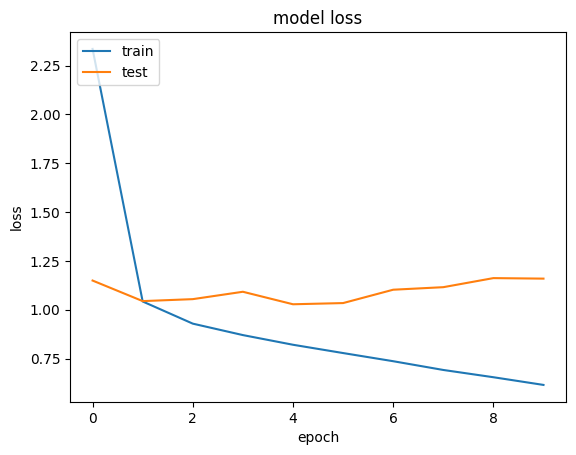

In [ ]:
#graph for model loss during test and train

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Extracting predictions for comments + quality

quality_prediction = text_classification_model.predict(test_quality)

64/64 [==============================] - 6s 30ms/step


In [ ]:
# Outputting predictions for comments + quality

print('Model Predictions for Comments + Quality')
quality_prediction[:15]

Model Predictions for Comments + Quality


array([[4.0140786],
       [4.31195  ],
       [4.476503 ],
       [4.123226 ],
       [4.642416 ],
       [4.2252245],
       [4.1607265],
       [4.698437 ],
       [4.8558774],
       [4.257351 ],
       [4.71572  ],
       [4.8047647],
       [4.9860773],
       [4.6383505],
       [4.74495  ]], dtype=float32)

In [ ]:
# Outputting average quality scores from original dataset

print('Original Comments + Quality Dataset')
for comment, quality in test_quality.take(15):
  print(np.average(quality.numpy()))

Original Comments + Quality Dataset
4.3046875
2.9765625
3.75
3.3984375
3.28125
2.609375
3.0546875
3.625
3.8515625
3.21875
2.9921875
3.5
3.5234375
3.03125
3.1015625


In [ ]:
quality_score = text_classification_model.evaluate(test_quality)

print('Test Loss for Comment + Quality: ', quality_score[0])
print('Test MSE for Comment + Quality: ', quality_score[1])
print('Test MAE for Comment + Quality: ', quality_score[2])
print('Test Accuracy for Comment + Quality: ', quality_score[3])

64/64 [==============================] - 2s 24ms/step - loss: 1.1405 - mse: 1.1405 - mae: 0.7791 - accuracy: 0.1376
Test Loss for Comment + Quality:  1.1405481100082397
Test MSE for Comment + Quality:  1.1405481100082397
Test MAE for Comment + Quality:  0.7791128158569336
Test Accuracy for Comment + Quality:  0.1375739574432373


**Training the text_classification_model on Comments + Difficulty Dataset**

In [ ]:
# Training the model on comments + difficulty dataset

history1=text_classification_model.fit(train_difficulty, epochs=10,validation_data=test_difficulty,
                    validation_steps=30)

Epoch 1/10
254/254 [==============================] - 26s 102ms/step - loss: 1.4800 - mse: 1.4800 - mae: 1.0045 - accuracy: 0.1734 - val_loss: 1.2855 - val_mse: 1.2855 - val_mae: 0.9330 - val_accuracy: 0.1307
Epoch 2/10
254/254 [==============================] - 26s 101ms/step - loss: 1.2093 - mse: 1.2093 - mae: 0.8981 - accuracy: 0.1734 - val_loss: 1.3197 - val_mse: 1.3197 - val_mae: 0.9249 - val_accuracy: 0.1307
Epoch 3/10
254/254 [==============================] - 25s 98ms/step - loss: 1.1310 - mse: 1.1310 - mae: 0.8637 - accuracy: 0.1734 - val_loss: 1.3256 - val_mse: 1.3256 - val_mae: 0.9361 - val_accuracy: 0.1307
Epoch 4/10
254/254 [==============================] - 24s 95ms/step - loss: 1.0594 - mse: 1.0594 - mae: 0.8335 - accuracy: 0.1734 - val_loss: 1.3850 - val_mse: 1.3850 - val_mae: 0.9583 - val_accuracy: 0.1307
Epoch 5/10
254/254 [==============================] - 25s 98ms/step - loss: 0.9917 - mse: 0.9917 - mae: 0.8045 - accuracy: 0.1734 - val_loss: 1.3898 - val_mse: 1.3898

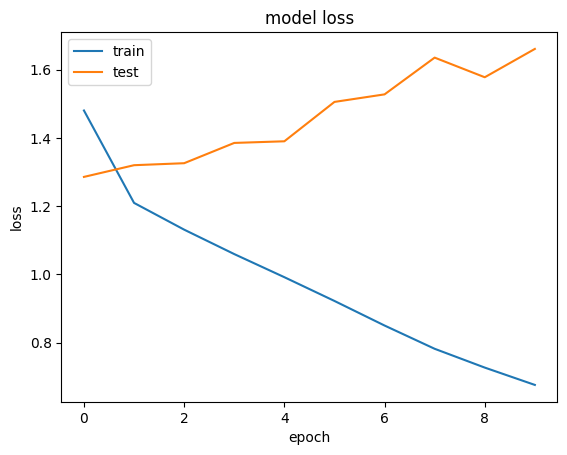

In [ ]:
#graph for model loss during test and train

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Extracting predictions for comments + difficulty

difficulty_prediction = text_classification_model.predict(test_difficulty)

64/64 [==============================] - 2s 26ms/step


In [ ]:
# Outputting predictions for comments + difficulty

print('Model Predictions for Comments + Difficulty')
difficulty_prediction[:15]

Model Predictions for Comments + Difficulty


array([[3.6973643],
       [3.5197186],
       [1.5837731],
       [3.2115076],
       [3.6552541],
       [1.7479787],
       [1.6452461],
       [2.4685345],
       [2.2331152],
       [3.3380375],
       [1.6327082],
       [2.9448009],
       [2.8006961],
       [1.415013 ],
       [3.198589 ]], dtype=float32)

In [ ]:
# Outputting average difficulty scores from original dataset

print('Original Comments + Difficulty Dataset')
for comment, difficulty in test_difficulty.take(15):
  print(np.average(difficulty.numpy()))

Original Comments + Difficulty Dataset
2.8125
3.25
2.8125
2.46875
3.65625
3.84375
3.53125
2.9375
3.796875
2.84375
3.59375
2.59375
3.15625
2.65625
2.84375


In [ ]:
difficulty_score = text_classification_model.evaluate(test_difficulty)

print('Test Loss for Comment + Difficulty:', difficulty_score[0])
print('Test MSE for Comment + Difficulty: ', difficulty_score[1])
print('Test MAE for Comment + Difficulty: ', difficulty_score[2])
print('Test Accuracy for Comment + Difficulty: ', difficulty_score[3])

64/64 [==============================] - 3s 41ms/step - loss: 1.6642 - mse: 1.6642 - mae: 1.0277 - accuracy: 0.1553
Test Loss for Comment + Difficulty: 1.6642346382141113
Test MSE for Comment + Difficulty:  1.6642346382141113
Test MAE for Comment + Difficulty:  1.027720332145691
Test Accuracy for Comment + Difficulty:  0.15532544255256653


**Saving text_classification_model**

In [ ]:
# Save Model

text_classification_model.save('text_classification_model')